In [1]:
import pandas as pd
import numpy as np
import os, sys
import statsmodels.api as sm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qfntools import DynamicBeta, FactorSelection

In [10]:
equity = pd.read_excel('../data/data2.xlsx',index_col=0, sheet_name='equity')
factor = pd.read_excel('../data/data2.xlsx',index_col=0, sheet_name='factor')

equity_ret = equity.pct_change().dropna()
# 24 assets: commodities (oil, corn, ...), currency, currency pair, bond, ... 
xRet = factor.pct_change().dropna()

# market return: SPX
marketRet = pd.DataFrame(equity_ret['SPX Index'])

In [3]:
# First, we find proper factors for our market model
# req_exp = 0.8, we want to find PCs of market return that explain 80% of total variation
# req_corr = 0.4, each factor should have at least abs(p)>=0.4 with one of the PCs of market return
# req_f_corr = 0.75, each factor should not have abs(p)>=0.75 with any other factors
fs = FactorSelection(req_exp=0.99999, req_corr=0.4, max_f_cor=0.6)
fs.fit(marketRet, xRet)

In [4]:
# selected factors are:
factor_names = fs.fac
factor_names

['AUDJPY CURNCY',
 'XOVER CDSI GENERIC 5Y Corp',
 'CITLY1U5 Index',
 'CJGB1U5 Index',
 'INR CURNCY',
 'CDBR1U5 Index',
 'DXY CURNCY',
 'HG1 COMDTY',
 'CO1 COMDTY']

In [5]:
# Correlation between PCs of market return and factors
fs.merged_df().corr()

,AUDJPY CURNCY,XOVER CDSI GENERIC 5Y Corp,CITLY1U5 Index,CJGB1U5 Index,INR CURNCY,CDBR1U5 Index,DXY CURNCY,HG1 COMDTY,CO1 COMDTY,PC1
AUDJPY CURNCY,1.000000,-0.463553,-0.502890,-0.360804,-0.493160,-0.441944,-0.501305,0.525401,0.484752,0.655851
XOVER CDSI GENERIC 5Y Corp,-0.463553,1.000000,0.593700,0.488723,0.379140,0.366102,0.252425,-0.227584,-0.262335,-0.643812
CITLY1U5 Index,-0.502890,0.593700,1.000000,0.576734,0.329592,0.578288,0.308386,-0.236168,-0.259823,-0.607695
CJGB1U5 Index,-0.360804,0.488723,0.576734,1.000000,0.286693,0.414617,0.280736,-0.267981,-0.291630,-0.567361
INR CURNCY,-0.493160,0.379140,0.329592,0.286693,1.000000,0.303732,0.519762,-0.331265,-0.270073,-0.530514
CDBR1U5 Index,-0.441944,0.366102,0.578288,0.414617,0.303732,1.000000,0.348249,-0.330244,-0.179346,-0.516072
DXY CURNCY,-0.501305,0.252425,0.308386,0.280736,0.519762,0.348249,1.000000,-0.517309,-0.516067,-0.496043
HG1 COMDTY,0.525401,-0.227584,-0.236168,-0.267981,-0.331265,-0.330244,-0.517309,1.000000,0.540435,0.477322
CO1 COMDTY,0.484752,-0.262335,-0.259823,-0.291630,-0.270073,-0.179346,-0.516067,0.540435,1.000000,0.418654
PC1,0.655851,-0.643812,-0.607695,-0.567361,-0.530514,-0.516072,-0.496043,0.477322,0.418654,1.000000


In [6]:
# R2 of our factor model
fs.R2

,R squared
SPX Index,0.684098


In [7]:
# return df of selected factors
factors_df = xRet[factor_names]

# Fit to dynamic beta model
db = DynamicBeta()
db.fit(y=marketRet, x=factors_df, factor_pca=False)

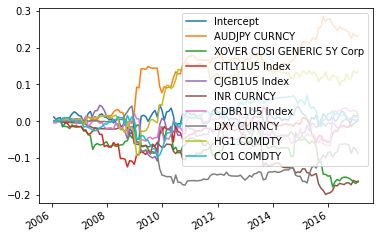

In [8]:
# As expected AUDJPY is the most important factor since 2008.
# This currency pair is well-known for representing bullishness. 
# Since AUD represent flow to commodities (main output of Australia is iron and coal). AUD strenghening means global demand is strong.
# JPY depreciation also represent bullishness. Since in bull market, people borrow JPY at negative rate, sell it for USD, and invest in US market.
# Therefore AUD/JPY rises when market is bullish.

db.plot(smoothed=False)

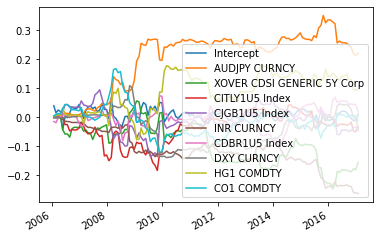

In [12]:
# We can even try to treat dependent variable Y as a random vector. 
# i.e. the factors need to explain returns of a group of assets at the same time.
# We can think of the betas as aggregated one for all equities in Y

equity_return = equity.pct_change
db = DynamicBeta()
db.fit(y=equity_ret, x=factors_df, factor_pca=False)

# AUDJPY is still the most important factor for a bunch of equities (not just one)
db.plot(smoothed=False)